In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eshetu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eshetu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pip install textblob

     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
     - ------------------------------------ 20.5/636.8 kB 50.4 kB/s eta 0:00:13
     --- --------------------------------- 61.4/636.8 kB 204.8 kB/s eta 0:00:03
     --- --------------------------------- 61.4/636.8 kB 204.8 kB/s eta 0:00:03
     ------ ----------------------------- 122.9/636.8 kB 343.4 kB/s eta 0:00:02
     ------ ----------------------------- 122.9/636.8 kB 343.4 kB/s eta 0:00:02
     -------- --------------------------- 143.4/636.8 kB 340.5 kB/s eta 0:00:02
     --------- -------------------------- 174.1/636.8 kB 361.7 kB/s eta 0:00:

In [4]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
import  sys
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from textblob import TextBlob


In [5]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('C:/Users/Eshetu/Desktop/Slack-Messages-Analysis-main')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [6]:
data_loader = SlackDataLoader(r"C:/Users/Eshetu/Desktop/10Academy/anonymized/")

def get_channel_messages(channel):
    channel_messages = utils.get_messages_on_channel(f"C:/Users/Eshetu/Desktop/10Academy/anonymized/{channel}") 
    # Create an empty DataFrame
    df = pd.DataFrame(channel_messages)
    return df

def get_all_channels_message():
    dfs = []  # List to store individual DataFrames

    for channel in data_loader.channels:
        dfs.append(get_channel_messages(channel["name"]))

    # Concatenate all DataFrames into a single DataFrame
    result_df = pd.concat(dfs, ignore_index=True)

    return result_df

In [7]:
def preprocess_text(text):
    # Extract and remove URLs
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    for url in urls:
        text = text.replace(url, '')

    text = re.sub(r'<@.*?>', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text


In [8]:
df = get_all_channels_message()
df['cleaned_text'] = df['text'].apply(preprocess_text)
df.head()

,text,ts,cleaned_text
0,<@U03TEPYRM2P> has joined the channel,1660301317.785879,join channel
1,<@U03T89ACUUW> has joined the channel,1660301593.241889,join channel
2,<@U03U9DB7REG> has joined the channel,1660833152.540199,join channel
3,<@U03UKL27B0R> has joined the channel,1660833720.685639,join channel
4,<@U03UL5LSTG9> has joined the channel,1660838313.991269,join channel


In [9]:
# Ensure the "ts" column is in a datetime format
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.head()

,text,ts,cleaned_text
0,<@U03TEPYRM2P> has joined the channel,2022-08-12 10:48:32,join channel
1,<@U03T89ACUUW> has joined the channel,2022-08-12 10:52:48,join channel
2,<@U03U9DB7REG> has joined the channel,2022-08-18 14:32:32,join channel
3,<@U03UKL27B0R> has joined the channel,2022-08-18 14:41:04,join channel
4,<@U03UL5LSTG9> has joined the channel,2022-08-18 15:57:52,join channel


In [10]:
# Group messages by day since the start of the training
df['day'] = df['ts'].dt.date
grouped_data = df.groupby('day')['cleaned_text'].agg(lambda x: ' '.join(x)).reset_index()

In [11]:
grouped_data.head()

,day,cleaned_text
0,2022-08-12,join channel join channel join channel join ch...
1,2022-08-18,join channel join channel join channel join ch...
2,2022-08-19,join channel join channel join channel join ch...
3,2022-08-20,join channel join channel join channel join ch...
4,2022-08-21,hi look forward start togeth tomorrow hello ev...


In [12]:
# Define a function to get sentiment polarity and subjectivity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [13]:
# Apply sentiment analysis to the aggregated messages
grouped_data[['sentiment_polarity', 'sentiment_subjectivity']] = grouped_data['cleaned_text'].apply(lambda x: pd.Series(get_sentiment(x)))


In [14]:
grouped_data.head()

,day,cleaned_text,sentiment_polarity,sentiment_subjectivity
0,2022-08-12,join channel join channel join channel join ch...,0.000000,0.00
1,2022-08-18,join channel join channel join channel join ch...,0.000000,0.00
2,2022-08-19,join channel join channel join channel join ch...,0.000000,0.00
3,2022-08-20,join channel join channel join channel join ch...,0.560000,0.95
4,2022-08-21,hi look forward start togeth tomorrow hello ev...,0.566667,1.00


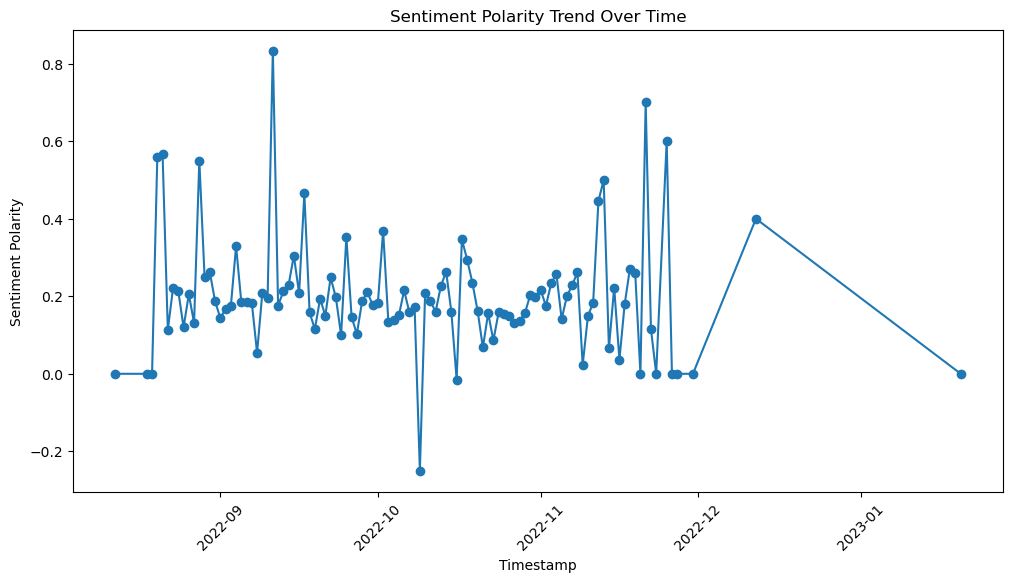

In [15]:
# Visualize the Time Series Trend for Sentiment Polarity
''' 
The x-axis represents timestamps (days), the y-axis represents sentiment polarity values, and each data point 
is marked with a circular marker. The plot provides a visual representation of the sentiment polarity trend.
'''
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['day'], grouped_data['sentiment_polarity'], marker='o')
plt.title('Sentiment Polarity Trend Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()

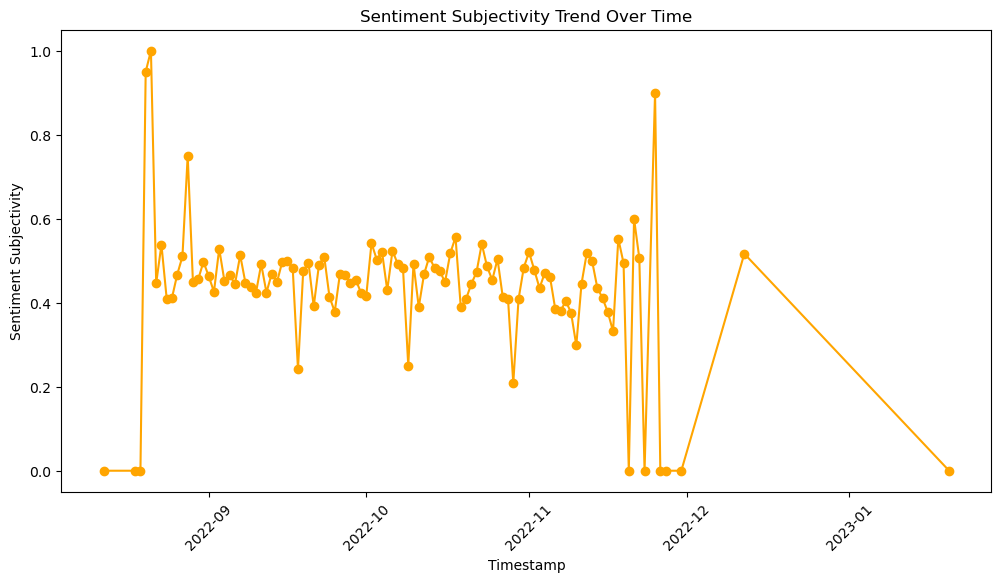

In [16]:
# Visualize the Time Series Trend for Sentiment Subjectivity
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['day'], grouped_data['sentiment_subjectivity'], marker='o', color='orange')
plt.title('Sentiment Subjectivity Trend Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Subjectivity')
plt.xticks(rotation=45)
plt.show()


In [21]:
def label_sentiments_in_dataframe(df, sentiment_polarity_column='sentiment_polarity', sentiment_subjectivity_column='sentiment_subjectivity'):
    """
    Label sentiments in a DataFrame based on sentiment polarity and subjectivity.

    Args:
    - df: DataFrame containing sentiment data.
    - sentiment_polarity_column: Name of the column containing sentiment polarity values.
    - sentiment_subjectivity_column: Name of the column containing sentiment subjectivity values.

    Returns:
    - DataFrame with an additional 'Label' column indicating sentiment categories.
    """

    def label_sentiment(row):
        # Extracting polarity and subjectivity from the columns
        polarity = row[sentiment_polarity_column]
        subjectivity = row[sentiment_subjectivity_column]

        # Detailed sentiment classification
        if polarity > 0.5 and subjectivity > 0.6:
            detailed_label = 'Strong Positive Opinion'
        elif 0.1 < polarity <= 0.5 and subjectivity > 0.6:
            detailed_label = 'Mild Positive Opinion'
        elif polarity > 0.5 and subjectivity < 0.4:
            detailed_label = 'Positive Fact'
        elif -0.1 <= polarity <= 0.1 and subjectivity > 0.6:
            detailed_label = 'Neutral Opinion'
        elif -0.1 <= polarity <= 0.1 and subjectivity < 0.4:
            detailed_label = 'Neutral Fact'
        elif -0.5 < polarity <= -0.1 and subjectivity > 0.6:
            detailed_label = 'Mild Negative Opinion'
        elif polarity < -0.5 and subjectivity > 0.6:
            detailed_label = 'Strong Negative Opinion'
        elif polarity < -0.5 and subjectivity < 0.4:
            detailed_label = 'Negative Fact'
        else:
            detailed_label = 'Negative Fact'

        # Mapping detailed categories to broader Positive, Neutral, Negative
        if 'Positive' in detailed_label:
            return 'Positive'
        elif 'Negative' in detailed_label:
            return 'Negative'
        elif 'Neutral' in detailed_label:
            return 'Neutral'
        else:
            return 'Unclassified'

    # Apply the label_sentiment function to each row in the DataFrame
    df['Label'] = df.apply(label_sentiment, axis=1)

    return df


In [22]:

# Call the function to add the 'Label' column
df_labeled = label_sentiments_in_dataframe(grouped_data)

In [23]:
df_labeled.head()

,day,cleaned_text,sentiment_polarity,sentiment_subjectivity,Label
0,2022-08-12,join channel join channel join channel join ch...,0.000000,0.00,Neutral
1,2022-08-18,join channel join channel join channel join ch...,0.000000,0.00,Neutral
2,2022-08-19,join channel join channel join channel join ch...,0.000000,0.00,Neutral
3,2022-08-20,join channel join channel join channel join ch...,0.560000,0.95,Positive
4,2022-08-21,hi look forward start togeth tomorrow hello ev...,0.566667,1.00,Positive


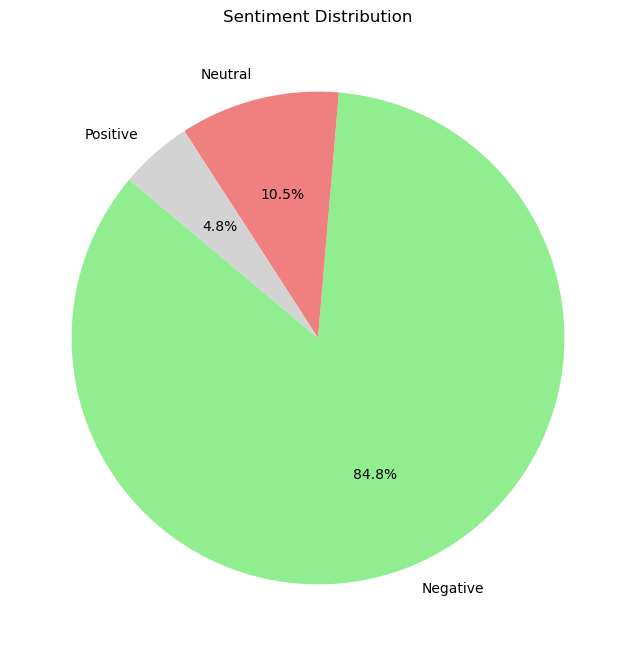

In [27]:
label_counts = df_labeled['Label'].value_counts()
# Define colors for each sentiment category
colors = ['lightgreen', 'lightcoral', 'lightgrey']
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Distribution')
plt.show()

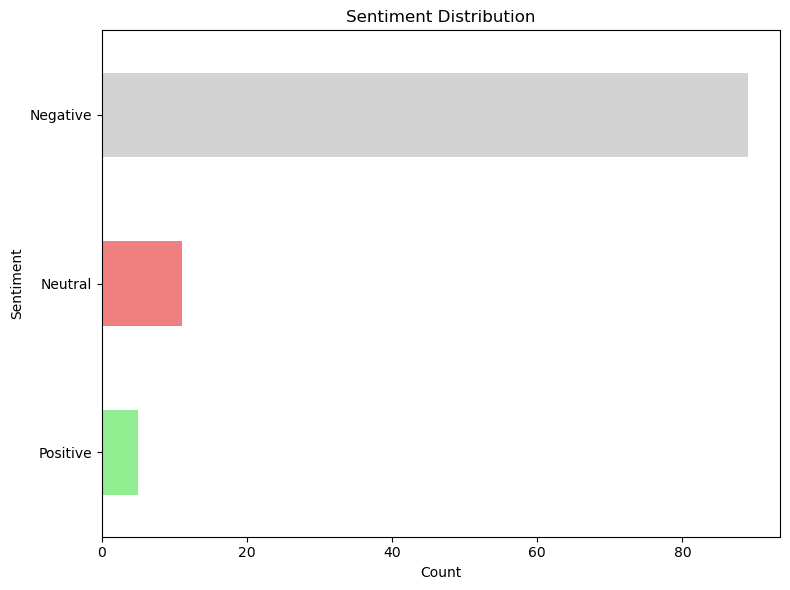

In [28]:

label_counts = df_labeled['Label'].value_counts()

# Define colors for each sentiment category
colors = ['lightgreen', 'lightcoral', 'lightgrey']

# Plotting the horizontal bar chart with custom colors
plt.figure(figsize=(8, 6))
label_counts.sort_values().plot(kind='barh', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()

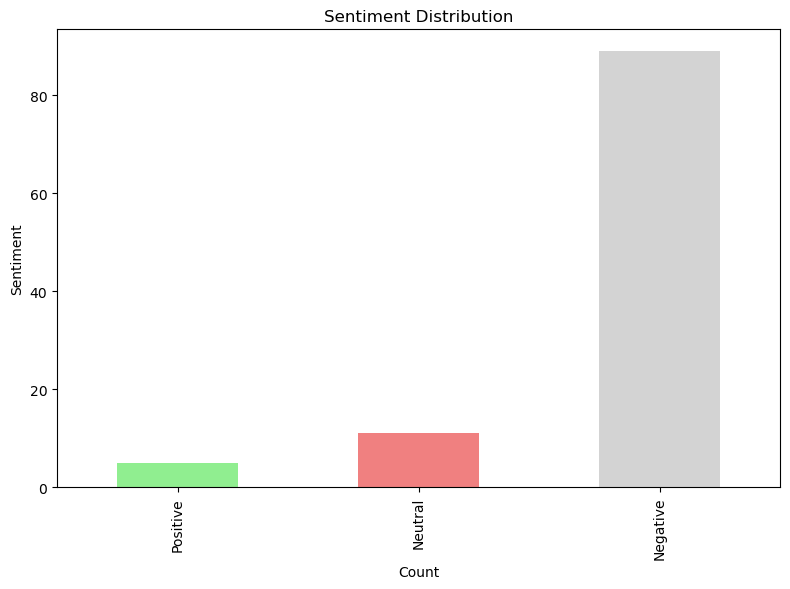

In [29]:

label_counts = df_labeled['Label'].value_counts()

# Define colors for each sentiment category
colors = ['lightgreen', 'lightcoral', 'lightgrey']

# Plotting the horizontal bar chart with custom colors
plt.figure(figsize=(8, 6))
label_counts.sort_values().plot(kind='bar', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()